In [1]:
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 6.0 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.6.2 which is incompatible.


In [2]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 6.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=73d28285851ba41c7bff118343f29b683caeb57207e8e577dd0fa7b37f2d970f
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [3]:
!pip install albumentations -q

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import table

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# plt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

import re
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

from catboost import CatBoostRegressor

import PIL
from PIL import ImageOps, ImageFilter

import os

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import pymorphy2
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


In [5]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Функции

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [9]:
#Функция подсчета количества уникальных значений в столбцах c данными типа Object
def object_data (data):
    columns = data.columns
    for i in columns:
        row = []
        if data[i].dtype == 'O':
            row.append(['count_of_observation', len(data[i])])
            row.append(['count_of_NaN', data[i].isnull().sum()])
            for j in range(len(data[i].value_counts())):
                row.append([list(data[i].value_counts().index)[j], list(data[i].value_counts())[j]])
            result = pd.DataFrame(row)
            print(i)
            print(result)
            print('')

In [10]:
# Функция для удаления размерности переменной (выбирает первое числовое значение)
def del_dimension (variable):
    pattern = re.compile('[0-9.]+')
    value = re.search(pattern, variable)
    if value != None:
        result = float(value[0])
    else: result = 0
    return result

In [11]:
# Функция выбора первого слова в строке
def first_name (variable):
    pattern = re.compile('\S+')
    name = re.match(pattern, variable)
    result = name.group(0)
    return result

In [12]:
# Функция для выбора популярных значений категориальных признаков
def top_variable (Series, percent):
    list_variable = Series.value_counts()
    top_variable = int(np.percentile(list_variable, percent))
    list_top_variable = list_variable[list_variable > top_variable]
    result = []
    for i in Series:
        if i in list_top_variable:
            result.append(i)
        else: result.append('other')
    return result

In [13]:
#Функция построения графиков для числовых переменных
def gist_draw (data):
    columns = data.columns
    for i in columns:
        if data[i].dtype == 'int64' or data[i].dtype == 'float64':
            row = []
            row.append(['count_of_observation', len(data[i])])
            row.append(['count_of_NaN', data[i].isnull().sum()])
            for j in range(len(data[i].describe())):
                row.append([list(data[i].describe().index)[j], list(data[i].describe().round(3))[j]])
            result = pd.DataFrame(data = row)
            x_right = data[i].max() * 2
            if data[i].max() < 0:
                loc_table = 2
            else: loc_table = 1
            fig, axes = plt.subplots (1,1)
            data[i].plot(kind = 'hist', xlim = (0, x_right * 2),  legend=None, title = i) 
            table(axes, result, loc = loc_table, colWidths=[0.4, 0.2, 0.9])#добавление таблицы с данными в график

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(data):
  columns = data.columns
  line = min(3, len(columns))
  rows = (len(columns) - 1) // line + 1
  fig = plt.figure(figsize = (line * 6, rows * 4))
  for i in range(len(columns)):
    j = columns[i]
    hist, bins = np.histogram(data[j], bins = 20)
    ax = fig.add_subplot(rows, line, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(j)
  plt.show()

In [15]:
#Построение графиков типа Boxplot
def get_boxplot(data):
    columns = data.columns
    for i in columns:
        for_plot = data[i].value_counts()
        fig, ax = plt.subplots(figsize = (16, 8))
        sns.boxplot(x=data[i], data=data[data[i].isin(data[i].value_counts())], ax=ax)
        ax.set_title('Boxplot for ' + i)
        plt.show()

In [16]:
def get_boxplot_2(data):
    columns = data.columns
    line = min(3, len(columns))
    rows = (len(columns) - 1) // line + 1
    fig = plt.figure(figsize = (line * 6, rows * 4))
    for i in range(len(columns)):
        j = columns[i]
        for_plot = data[j].value_counts()
        ax = fig.add_subplot(rows, line, i + 1)
        ax.boxplot(x=data[j], data=data[data[j].isin(for_plot)], vert = False)
        ax.set_title('Boxplot for ' + j)
    plt.show()

In [17]:
# Выделение времени владения
def get_work_time(variable):
    var = []
    result = 0
    if variable != 0:
        var = variable.split(' ')
        year = 0
        month = 0
        for i in range(len(var)):
            if var[i].find('мес') == 0:
                month = int(var[i-1])
            elif var[i].find('мес') == -1 and i >= 1:
                year = int(var[0])
        result = 12 * year + month    
    return result

In [18]:
# Функция удаления знаков из текста
def remove_chars_from_text(text, chars):
    result = ''
    for i in text:
        if i in chars:
            result += ''.join(' ')
        else: result += ''.join(i)
    return result

In [19]:
# Функция для лемматизации
def compare_lemmatizer(text):
    words = word_tokenize(text)
    morph = pymorphy2.MorphAnalyzer()
    result = []
    for word in words:
        var = morph.parse(word)[0]
        result.append(var.normal_form)
    return result

In [20]:
# Функция удаления слов из списка stop words
def remove_stop_words (text, stop_words):
    result = []
    for word in text:
        if word in stop_words:
            result = result
        else: result.append(word)
    return result

In [21]:
def pred_text (text, chars, stop_words):
    text = text.lower() # все знаки нижний реестр
    words = ''
    for i in text: #удаляем знаки
        if i in chars:
            words += ''.join(' ')
        else: words += ''.join(i)
    words = word_tokenize(words)
    morph = pymorphy2.MorphAnalyzer()
    result = []
    for word in words:
        var = morph.parse(word)[0]
        word_normal = str(var.normal_form)
        if word_normal not in stop_words and len(word_normal) > 1: # проверка stop_words и длина слова
            result.append(word_normal)
    return result

# DATA


Исходные данные представлены в виде таблиц в формате *.csv и изображений в формате *.jpg.  

In [22]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')



In [23]:
train.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [25]:
test.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [27]:
sample_submission.head(2)

,sell_id,price
0,1099427284,0
1,1096405886,0


In [28]:

# объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price

In [29]:
data_base = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [30]:
data = data_base.copy()

In [31]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,2006,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый,1,550000.0
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,2016,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,1900000.0
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,2008,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,530000.0
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,2016,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,1970000.0


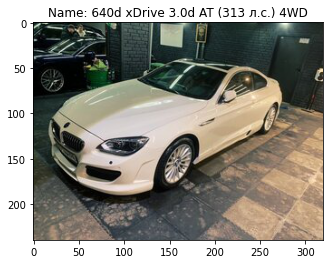

(320, 240)

In [32]:
# Рассмотрим изображения
image = PIL.Image.open(f"{DATA_DIR}img/img/{data['sell_id'][1]}.jpg")
imgplot = plt.imshow(image)
plt.title('Name: '+str(data['name'][1]))
plt.show()
image.size

# Model 1: Создадим "наивную" модель

Эта модель будет предсказывать среднюю цену по модели и году выпуска. C ней будем сравнивать другие модели.


In [33]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [34]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"(model_info == '{row[0]}') and (productionDate == {row[1]})"
    predicts.append(data_train.query(query)['price'].median())

#заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA/Анализ данных



Посмотрим на типы признаков:

    bodyType - категориальный
    brand - категориальный
    color - категориальный
    description - текстовый
    engineDisplacement - числовой, представленный как текст
    enginePower - числовой, представленный как текст
    fuelType - категориальный
    mileage - числовой
    modelDate - числовой
    model_info - категориальный
    name - категориальный, желательно сократить размерность
    numberOfDoors - категориальный
    price - числовой, целевой
    productionDate - числовой
    sell_id - изображение (файл доступен по адресу, основанному на sell_id)
    vehicleConfiguration - не используется (комбинация других столбцов)
    vehicleTransmission - категориальный
    Владельцы - категориальный
    Владение - числовой, представленный как текст
    ПТС - категориальный
    Привод - категориальный
    Руль - категориальный

In [35]:
#уберем размерность из столбцов "engineDisplacement" и "enginePower"
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x : del_dimension(x))
data['enginePower'] = data['enginePower'].apply(lambda x : del_dimension(x))
#Удалим столбец "vehicleConfiguration"
data = data.drop('vehicleConfiguration', axis = 1)

In [36]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name', 'numberOfDoors' , 'vehicleTransmission', 'Владельцы' , 'ПТС', 'Привод', 'Руль']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'Владение']
text_cols = ['description']
img_cols = ['sell_id']

## Категориальные переменные

In [37]:
#Рассмотрим значение данных
object_data(data[cat_cols])

bodyType
                       0     1
0   count_of_observation  8353
1           count_of_NaN     0
2                  седан  3541
3      внедорожник 5 дв.  2896
4                   купе   543
5          хэтчбек 5 дв.   364
6                лифтбек   299
7        универсал 5 дв.   196
8                минивэн   178
9           купе-хардтоп   111
10               родстер    88
11         хэтчбек 3 дв.    57
12             кабриолет    54
13            компактвэн     8
14     внедорожник 3 дв.     5
15               лимузин     5
16  внедорожник открытый     4
17  пикап двойная кабина     3
18           седан 2 дв.     1

brand
                      0     1
0  count_of_observation  8353
1          count_of_NaN     0
2                   BMW  3535
3              MERCEDES  2846
4                  AUDI  1972

color
                       0     1
0   count_of_observation  8353
1           count_of_NaN     0
2                 чёрный  3468
3                  белый  1607
4                  сер

Обработка данных:
 - столбец "bodyType" содержит дублирующую информацию (кол-во дверей);
 - столбец "brend" оставляем без изменений;
 - столбец "color" оставляем без изменений;
 - столбец "name" содержит дублирующую информацию (объем двигателя, мощность);
 - столбец "vehicleTransmission" оставляем без изменения;
 - столбец "Влядельцы" оставляем без изменений;
 - столбец "ПТС" оставляем без изменений;
 - столбец "Привод" оставляем без изменений;
 - столбец "Руль" можно удалить, так как в выборке присутствует всего 2 машины с правым рулем.

In [38]:
# столбцы "bodyType" и "Руль"
data['bodyType'] = data['bodyType'].apply(lambda x : first_name(x))
data = data.drop('Руль', axis = 1)
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name', 'numberOfDoors' , 'vehicleTransmission', 'Владельцы' , 'ПТС', 'Привод']

In [39]:
data[data['brand'] == 'BMW'][['model_info', 'name']]

,model_info,name
1,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD
2,3ER,325xi 2.5 AT (218 л.с.) 4WD
3,3ER,318i 2.0 AT (136 л.с.)
4,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD
5,5ER,540i xDrive 3.0 AT (340 л.с.) 4WD
...,...,...
8344,X4,20d 2.0d AT (190 л.с.) 4WD
8345,X3,25i 2.5 AT (218 л.с.) 4WD
8348,3ER,320i 2.0 AT (150 л.с.)
8349,5ER,520d 2.0d AT (190 л.с.)


In [40]:
data[data['brand'] == 'MERCEDES'][['model_info', 'name']]

,model_info,name
0,W124,300 3.0 AT (220 л.с.)
7,SL_KLASSE,350 3.5 AT (316 л.с.)
10,SL_KLASSE,300 3.0 AT (231 л.с.)
12,GL_KLASSE,500 5.5 AT (388 л.с.) 4WD
19,S_KLASSE,500 4.7 AT (455 л.с.) 4WD
...,...,...
8339,CLA_KLASSE,200 1.6 AMT (156 л.с.)
8340,GLC_KLASSE_AMG,43 AMG 3.0 AT (367 л.с.) 4WD
8343,S_KLASSE,350 CDI BlueTEC 3.0d AT (249 л.с.) 4WD
8347,GLK_KLASSE,300 3.0 AT (231 л.с.) 4WD


In [41]:
#Уберем дублирующую информацию из столбца "name"
for i in range(len(data)):
    num_str = data.loc[i,'name'].find(str(data.loc[i, 'engineDisplacement']))
    if num_str > 0:
        data.loc[i, 'name'] = data.loc[i,'name'].split(f" {str(data.loc[i, 'engineDisplacement'])}")[0]
    elif num_str == 0:
        data.loc[i, 'name'] = 'other'
    else:
        data.loc[i, 'name'] = data.loc[i, 'name']

In [42]:
# В столбце "name" оставим информацию попадающие по количеству более 90 процентиля
data['name'] = top_variable(data['name'], 90)

In [43]:
 data['name']

0               300
1             other
2             other
3              318i
4       520d xDrive
           ...     
8348           320i
8349           520d
8350           318i
8351           Long
8352          other
Name: name, Length: 8353, dtype: object

In [44]:
data.loc[1, 'name']

'other'

In [45]:
object_data(data[cat_cols])

bodyType
                       0     1
0   count_of_observation  8353
1           count_of_NaN     0
2                  седан  3542
3            внедорожник  2905
4                   купе   543
5                хэтчбек   421
6                лифтбек   299
7              универсал   196
8                минивэн   178
9           купе-хардтоп   111
10               родстер    88
11             кабриолет    54
12            компактвэн     8
13               лимузин     5
14                 пикап     3

brand
                      0     1
0  count_of_observation  8353
1          count_of_NaN     0
2                   BMW  3535
3              MERCEDES  2846
4                  AUDI  1972

color
                       0     1
0   count_of_observation  8353
1           count_of_NaN     0
2                 чёрный  3468
3                  белый  1607
4                  серый   925
5                  синий   863
6            серебристый   420
7             коричневый   386
8                красн

In [46]:
data[data['brand'] == 'MERCEDES']['name'].value_counts()

other              1029
200                 459
500                 208
350                 203
180                 179
63 AMG              175
250                 134
400                 113
300                 112
350 d               103
350 CDI BlueTEC      69
320                  62
Name: name, dtype: int64

Рассмотрим строку с значением None в столбце "model_info"

In [47]:
data[data['model_info'] == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0,510.0,бензин,41000,2014,None,other,4,2017,1099323364,автоматическая,3 или более,NaN,Дубликат,задний,1,3700000.0


In [48]:
data[(data['brand'] == 'MERCEDES') & (data['enginePower'] == 510.0) & (data['engineDisplacement'] == 4.0) & (data['bodyType'] == 'седан')]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,sample,price
2601,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,4.0,510.0,бензин,137,2018,C_KLASSE_AMG,other,4,2019,1099370722,автоматическая,1 владелец,NaN,Оригинал,задний,1,6885150.0
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0,510.0,бензин,41000,2014,None,other,4,2017,1099323364,автоматическая,3 или более,NaN,Дубликат,задний,1,3700000.0
6564,седан,MERCEDES,чёрный,Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...,4.0,510.0,бензин,933,2018,C_KLASSE_AMG,other,4,2019,1099892640,автоматическая,1 владелец,NaN,Оригинал,задний,1,6298000.0


In [49]:
data_base.loc[2803]

bodyType                                                            седан
brand                                                            MERCEDES
color                                                               серый
description             Автомобиль в очень хорошем состоянии. Богатая ...
engineDisplacement                                                4.0 LTR
enginePower                                                       510 N12
fuelType                                                           бензин
mileage                                                             41000
modelDate                                                            2014
model_info                                                           None
name                                           63 AMG S 4.0 AT (510 л.с.)
numberOfDoors                                                           4
productionDate                                                       2017
sell_id                               

In [50]:
data_base[(data_base['brand'] == 'MERCEDES') & (data_base['enginePower'] == '510 N12') & (data_base['engineDisplacement'] == '4.0 LTR') & (data_base['bodyType'] == 'седан')]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2601,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,4.0 LTR,510 N12,бензин,137,2018,C_KLASSE_AMG,63 AMG S 4.0 AT (510 л.с.),4,2019,1099370722,SEDAN AUTOMATIC 4.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,6885150.0
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0 LTR,510 N12,бензин,41000,2014,None,63 AMG S 4.0 AT (510 л.с.),4,2017,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0
6564,седан,MERCEDES,чёрный,Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...,4.0 LTR,510 N12,бензин,933,2018,C_KLASSE_AMG,63 AMG S 4.0 AT (510 л.с.),4,2019,1099892640,SEDAN AUTOMATIC 4.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,6298000.0


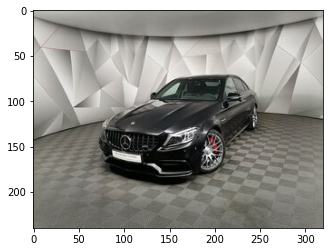

(320, 240)

In [51]:
# Рассмотрим изображения
image = PIL.Image.open(f"{DATA_DIR}img/img/1099370722.jpg")
imgplot = plt.imshow(image)
plt.show()
image.size

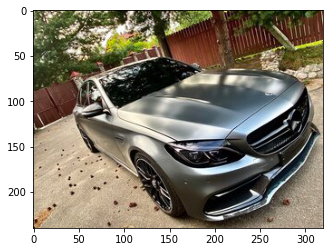

(320, 240)

In [52]:
# Рассмотрим изображения
image = PIL.Image.open(f"{DATA_DIR}img/img/1099323364.jpg")
imgplot = plt.imshow(image)
plt.show()
image.size

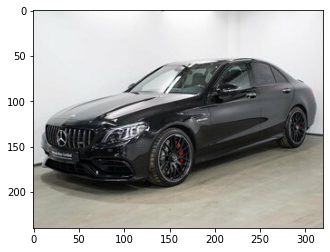

(320, 240)

In [53]:
# Рассмотрим изображения
image = PIL.Image.open(f"{DATA_DIR}img/img/1099892640.jpg")
imgplot = plt.imshow(image)
plt.show()
image.size

In [54]:
# Примем
data.loc[2803, 'model_info'] = 'C_KLASSE_AMG'

In [55]:
data.loc[2803,:]

bodyType                                                           седан
brand                                                           MERCEDES
color                                                              серый
description            Автомобиль в очень хорошем состоянии. Богатая ...
engineDisplacement                                                     4
enginePower                                                          510
fuelType                                                          бензин
mileage                                                            41000
modelDate                                                           2014
model_info                                                  C_KLASSE_AMG
name                                                               other
numberOfDoors                                                          4
productionDate                                                      2017
sell_id                                            

In [56]:
# В столбце "model_info" оставим информацию попадающие по количеству более 80 процентиля
data['model_info'] = top_variable(data['model_info'], 80)

In [57]:
data['model_info'].value_counts().head(50)

other         2013
5ER            776
3ER            578
X5             501
E_KLASSE       490
A6             433
A4             297
S_KLASSE       282
7ER            276
C_KLASSE       274
X6             269
X3             268
Q7             205
Q5             196
A5             186
1ER            179
M_KLASSE       169
X1             158
GL_KLASSE      141
A3             132
A8             129
G_KLASSE       113
6ER            107
CLS_KLASSE      94
Q3              87
Name: model_info, dtype: int64

In [58]:
#Найдем NaN в столбце "Владельцы"
data_nan = data['Владельцы'].isnull()
for i in range(len(data_nan)):
    if data_nan[i] == True:
        print(data.loc[i,:])

bodyType                                                           седан
brand                                                               AUDI
color                                                             чёрный
description            машина в идеале! вложено примерно 400тыс.руб \...
engineDisplacement                                                   4.2
enginePower                                                          360
fuelType                                                          бензин
mileage                                                           160000
modelDate                                                           1999
model_info                                                         other
name                                                               other
numberOfDoors                                                          4
productionDate                                                      2001
sell_id                                            

In [59]:
# Автомобиль 1999 года выпуска, скорее всего у него было 3 и более владельца
data = data.fillna({'Владельцы' : '3 или более'})

In [60]:
object_data(data[cat_cols])

bodyType
                       0     1
0   count_of_observation  8353
1           count_of_NaN     0
2                  седан  3542
3            внедорожник  2905
4                   купе   543
5                хэтчбек   421
6                лифтбек   299
7              универсал   196
8                минивэн   178
9           купе-хардтоп   111
10               родстер    88
11             кабриолет    54
12            компактвэн     8
13               лимузин     5
14                 пикап     3

brand
                      0     1
0  count_of_observation  8353
1          count_of_NaN     0
2                   BMW  3535
3              MERCEDES  2846
4                  AUDI  1972

color
                       0     1
0   count_of_observation  8353
1           count_of_NaN     0
2                 чёрный  3468
3                  белый  1607
4                  серый   925
5                  синий   863
6            серебристый   420
7             коричневый   386
8                красн

Заменим строковые величины в категориальных признаках на числовые (закодируем)

In [61]:
# используем OrdinalEncoder
enc = OrdinalEncoder()
for i in range(len(cat_cols)):    
    data[cat_cols[i]] = enc.fit_transform(np.array(data[cat_cols[i]]).reshape(-1, 1))

In [62]:
data[cat_cols]

,bodyType,brand,color,fuelType,model_info,name,numberOfDoors,vehicleTransmission,Владельцы,ПТС,Привод
0,11.0,2.0,15.0,0.0,24.0,7.0,3.0,0.0,2.0,1.0,0.0
1,3.0,1.0,1.0,2.0,3.0,29.0,0.0,0.0,0.0,1.0,2.0
2,3.0,1.0,9.0,0.0,1.0,29.0,0.0,0.0,2.0,1.0,2.0
3,10.0,1.0,1.0,0.0,1.0,9.0,2.0,0.0,1.0,1.0,0.0
4,10.0,1.0,15.0,2.0,2.0,22.0,2.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
8348,10.0,1.0,12.0,0.0,1.0,12.0,2.0,0.0,2.0,1.0,0.0
8349,10.0,1.0,15.0,2.0,2.0,21.0,2.0,0.0,2.0,1.0,0.0
8350,10.0,1.0,1.0,0.0,1.0,9.0,2.0,0.0,2.0,1.0,0.0
8351,10.0,0.0,15.0,0.0,9.0,28.0,2.0,0.0,2.0,1.0,2.0


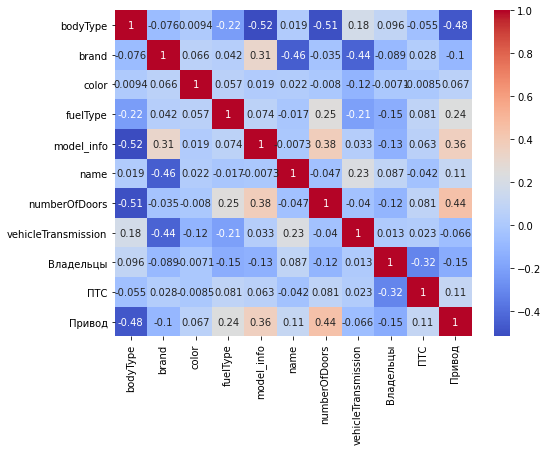

In [63]:
#Проверим корреляционную зависимость категориальных и бинарных переменных 
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data[cat_cols].corr(method = 'spearman'),annot = True, cmap = 'coolwarm')

<AxesSubplot:>

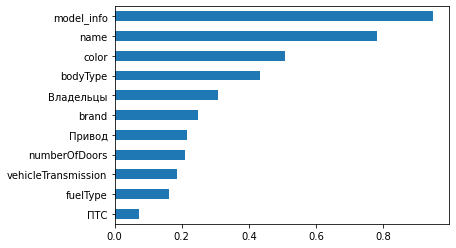

In [64]:
#Значимость категориальных переменных
imp_cat = pd.Series(mutual_info_classif(data[cat_cols], data['price'], discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Числовые переменные

In [65]:
print(num_cols)

['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'Владение']


In [66]:
#добавим столбец "operating_time" и "model_time" (информацию представим в месяцах)
data['operating_time'] = data['productionDate'].apply(lambda x: (2021 - x) * 12)
data['model_time'] = data['modelDate'].apply(lambda x: (2021 - x) * 12)

Рассмотрим столбец 'Владение'.

In [67]:
data = data.fillna({'Владение' : 0})

In [68]:
data['Владение'].value_counts().head()

0                    5418
1 год и 8 месяцев      67
1 год и 2 месяца       67
1 год                  55
9 месяцев              52
Name: Владение, dtype: int64

In [69]:
data['Владение'] = data['Владение'].apply(lambda x: get_work_time(x))

In [70]:
data['Владение'].value_counts().head()

0     5418
20      67
14      67
12      55
26      52
Name: Владение, dtype: int64

In [71]:
# Информация о владельцах после кодирования
data['Владельцы'].value_counts()

2.0    3312
0.0    2526
1.0    2515
Name: Владельцы, dtype: int64

Расшифровка:
   - 2.0 - 3 и более владельца
   - 0.0 - 1 владельц
   - 1.0 - 2 владелеца

2.0


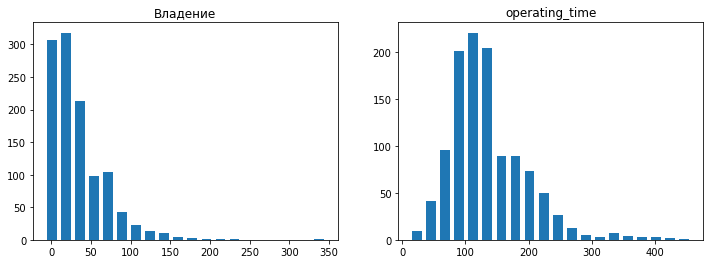

0.0


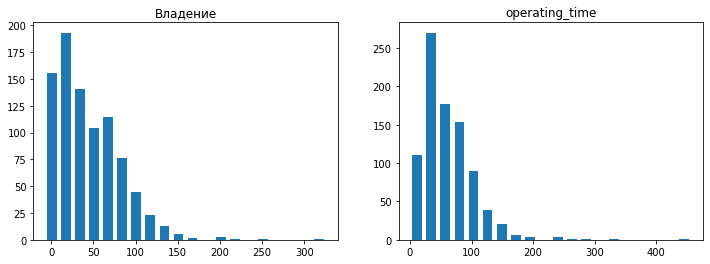

1.0


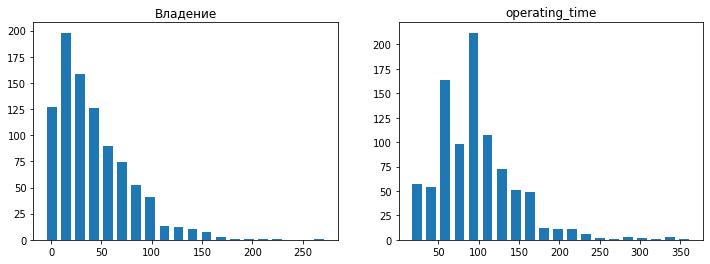

In [72]:
# Рассмотрим данные в столбце "Владение" и "operating_time"
for i in data['Владельцы'].value_counts().index:
    print(i)
    visualize_distributions(data[(data['Владельцы'] == i) & (data['Владение'] != 0)][['Владение','operating_time']])

Из графиков видно, что характер распределения данных в столбце "Владение" имеют одинаковый характер и имеет вид логнормального распределения. Для заполнения пропусков в столбце "Владение" воспользуемся следующими правилами:
   - если владелец 1, то Владение = operating_time, графики распределения похожи данных похожи друг на друга;
   - если владельцев 2 , то Владение = operating_time * 0,25 ;
   - если владельцев 3 и более пропуски заменим на наиболее часто встречающиеся значения.

In [73]:
for i in data['Владельцы'].value_counts().index:
    if i == 0:
        var_index = data[(data['Владельцы'] == i) & (data['Владение'] == 0)].index
        data.loc[var_index,'Владение'] =  data.loc[var_index,'operating_time']
    elif i == 1:
        var_index = data[(data['Владельцы'] == i) & (data['Владение'] == 0)].index
        value = data.loc[var_index,'operating_time'].to_numpy() * 0.25
        data.loc[var_index,'Владение'] = value 
    else:
        var_index = data[(data['Владельцы'] == i) & (data['Владение'] == 0)].index
        mode_index = data[(data['Владельцы'] == i) & (data['Владение'] != 0)].index
        value = data.loc[mode_index,'Владение'].mode()[0]
        value = value * np.ones(len(var_index)).reshape(-1, 1)
        data.loc[var_index,'Владение'] = value   

In [74]:
data['Владение'].value_counts().head(25)

14.0     2238
24.0      529
36.0      353
12.0      270
48.0      222
21.0      214
27.0      212
18.0      196
15.0      195
60.0      184
30.0      177
72.0      160
84.0      152
9.0       138
96.0      130
33.0      123
39.0      111
108.0      93
42.0       69
20.0       67
120.0      58
6.0        57
22.0       52
26.0       52
17.0       51
Name: Владение, dtype: int64

In [75]:
data['Владение']

0       75.0
1       78.0
2       14.0
3       42.0
4       24.0
        ... 
8348    14.0
8349    26.0
8350    26.0
8351    14.0
8352    75.0
Name: Владение, Length: 8353, dtype: float64

In [76]:
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'model_time', 'operating_time', 'Владение']

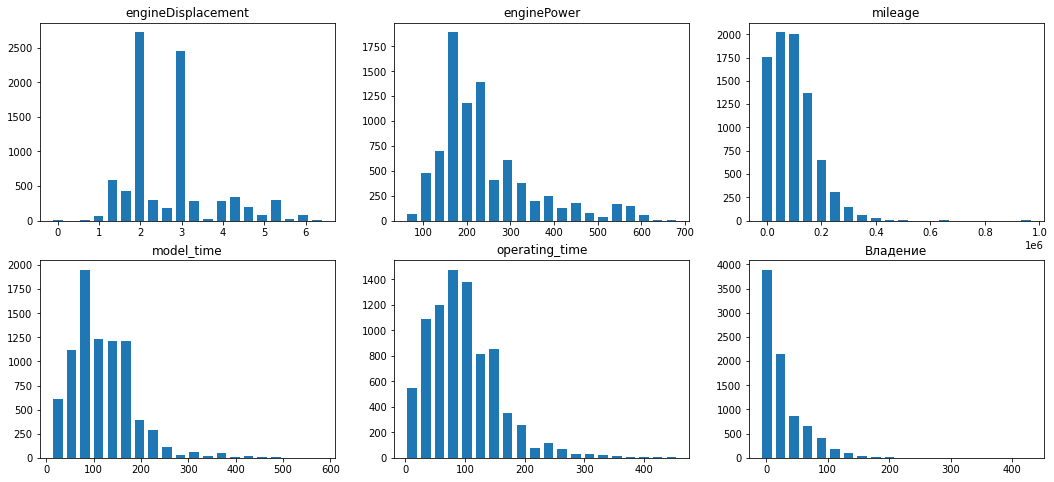

In [77]:
# Рассмотрим данные
visualize_distributions(data[num_cols])

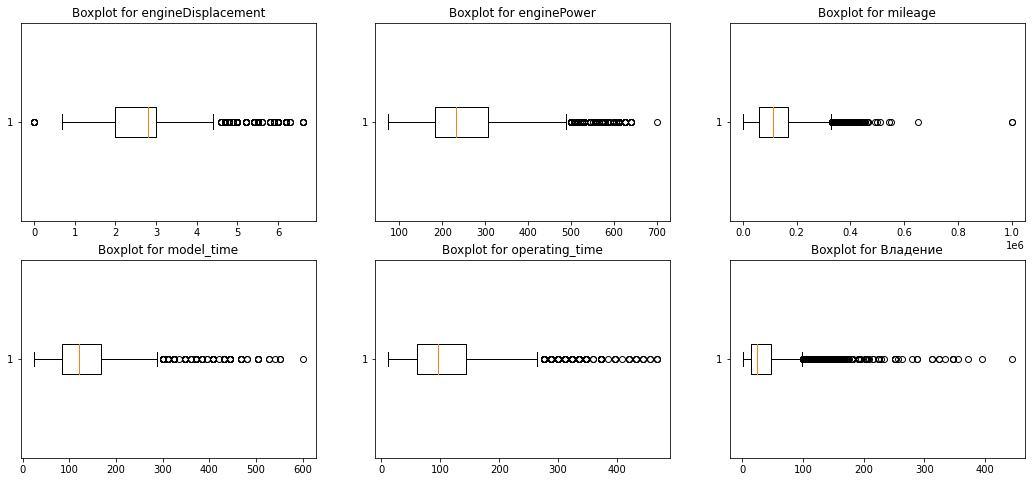

In [78]:
get_boxplot_2(data[num_cols])

Данные в столбце "engineDisplacement" оставим без изменений, данные явно имеют два максимально встречающихся значения.
Данные в столбцах 'enginePower', 'mileage', 'modelDate', 'operating_time', 'Владение' прологарифмируем.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


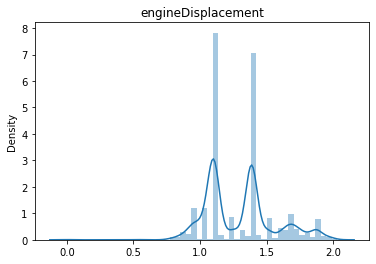

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


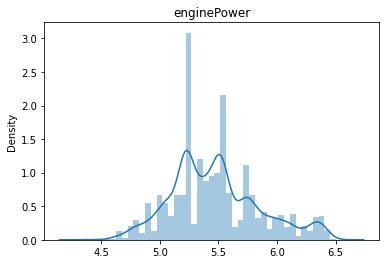

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


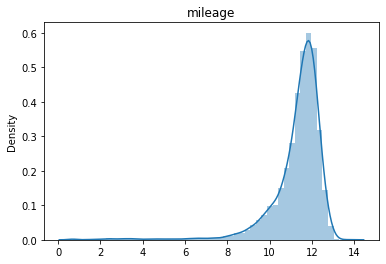

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


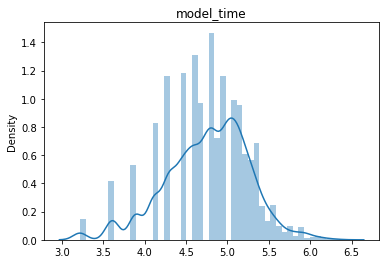

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


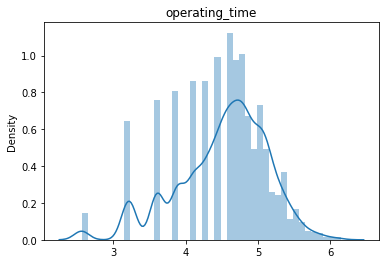

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


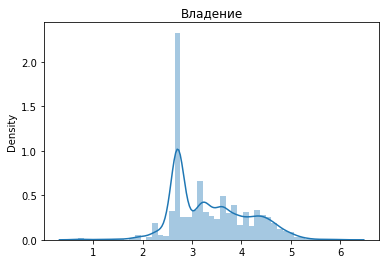

In [79]:
for i in data[num_cols]:
    arr_log = np.log(np.array(data[i])+1)
    plt.figure()
    sns.distplot(arr_log, kde = True, rug = False)
    plt.title(i)
    plt.show()

Прологарифмируем данные для столбцов 'mileage', 'modelDate', 'operating_time', 'Владение'

In [80]:
data['mileage'] = data['mileage'].apply(lambda x: np.log(x+1))
data['model_time'] = data['model_time'].apply(lambda x: np.log(x+1))
data['operating_time'] = data['operating_time'].apply(lambda x: np.log(x+1))
data['Владение'] = data['Владение'].apply(lambda x: np.log(x+1))

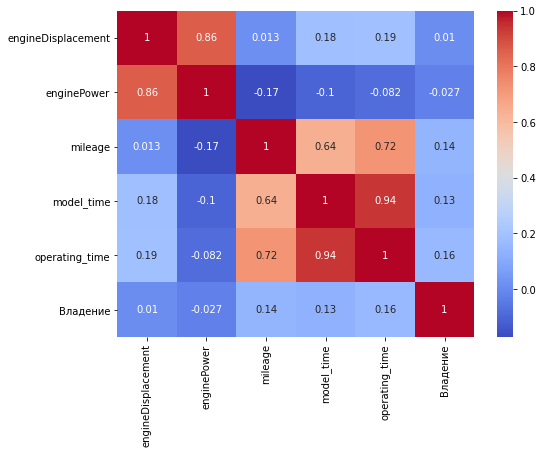

In [81]:
#Корреляционная зависимость числовых переменных
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data[num_cols].corr(),annot = True, cmap = 'coolwarm')

Высокая корреляционная зависимость между данными в столбцах "enginPower" и "enginDisplacement",  "operating_time" и "mileage", отрицательная кореляционная зависимость между данными в столбце "modelDate" и "operating_tame" (чем позже появилась марка на рынке, тем меньше у нее время на эксплуатацию)

<AxesSubplot:>

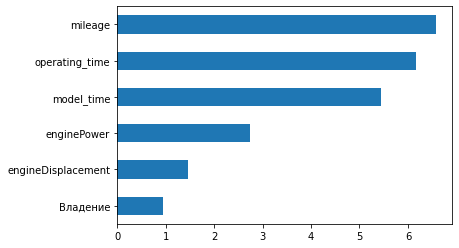

In [82]:
#Значимость числовых переменных
imp_num = pd.Series(f_classif(data[num_cols], data['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

с учетом значимости признаков исключим из дальнейшей работы столбцы  "operating_time", "enginDisplacement"

# Данные для обучения

#### Категориальные признаки

In [83]:
df_dummies = pd.DataFrame(OneHotEncoder(sparse = False).fit_transform(data[cat_cols]))

In [84]:
df_dummies.shape

(8353, 107)

### Числовые переменные

In [85]:
#MinMaxScaler #pd.DataFrame(StandardScaler().fit_transform(data[num_cols].values), columns = num_cols)

In [86]:
df_num = pd.DataFrame(MinMaxScaler().fit_transform(data[num_cols].values), columns = num_cols)

In [87]:
df_num.shape

(8353, 6)

### Данные для обучения

In [88]:
data_learn = df_dummies.copy()
data_learn = data_learn.join(df_num)

In [89]:
# добавим столбец "price" и "sample"
data_learn = data_learn.join(data[['price', 'sample']])

In [90]:
data_learn.shape

(8353, 115)

### Split Data

In [91]:
# Теперь выделим тестовую часть
train_data = data_learn.query('sample == 1').drop(['sample'], axis=1)
test_data = data_learn.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)


# Model 2: CatBoostRegressor

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [93]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,engineDisplacement,enginePower,mileage,model_time,operating_time,Владение
7320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.909091,0.7504,0.855429,0.577840,0.622158,0.746401
8037,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.303030,0.2720,0.705392,0.280527,0.291709,0.539835
4681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.469697,0.2880,0.846775,0.661736,0.734468,0.372790
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.272727,0.1744,0.915514,0.622577,0.715337,0.682503
3649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.454545,0.3808,0.842142,0.495929,0.560501,0.680176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.454545,0.2784,0.816237,0.337006,0.431142,0.571893
6862,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.303030,0.1744,0.676741,0.211636,0.182373,0.467301
6897,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.454545,0.2720,0.839057,0.525667,0.622158,0.372790
7061,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.454545,0.2784,0.833844,0.337006,0.370050,0.549575


In [94]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )


Learning rate set to 0.023474
0:	learn: 0.9861072	test: 1.0105044	best: 1.0105044 (0)	total: 55.9ms	remaining: 4m 39s
100:	learn: 0.2901795	test: 0.2908349	best: 0.2908349 (100)	total: 302ms	remaining: 14.6s
200:	learn: 0.2022193	test: 0.2025678	best: 0.2025678 (200)	total: 540ms	remaining: 12.9s
300:	learn: 0.1768629	test: 0.1793811	best: 0.1793811 (300)	total: 790ms	remaining: 12.3s
400:	learn: 0.1645090	test: 0.1688323	best: 0.1688099 (399)	total: 1.24s	remaining: 14.2s
500:	learn: 0.1584939	test: 0.1636729	best: 0.1636729 (500)	total: 1.58s	remaining: 14.2s
600:	learn: 0.1526509	test: 0.1599282	best: 0.1599282 (600)	total: 1.82s	remaining: 13.3s
700:	learn: 0.1474938	test: 0.1570242	best: 0.1569748 (697)	total: 2.05s	remaining: 12.6s
800:	learn: 0.1433740	test: 0.1539442	best: 0.1539339 (799)	total: 2.29s	remaining: 12s
900:	learn: 0.1390997	test: 0.1507380	best: 0.1507380 (900)	total: 2.52s	remaining: 11.5s
1000:	learn: 0.1348503	test: 0.1478114	best: 0.1478114 (1000)	total: 2.76s

In [95]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 13.12%


### Submission

In [96]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

In [97]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               58368     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 189,953
Trainable params: 189,953
Non-trainable params: 0
_________________________________________________________________


In [99]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [100]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [101]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

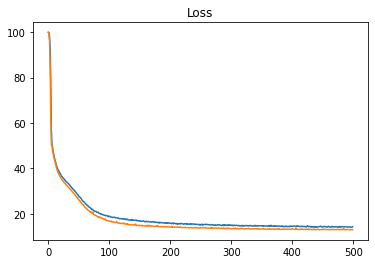

In [102]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [103]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [104]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.99%


In [105]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [106]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

### Предварительная обработка техта

In [107]:
spec_chars = string.punctuation + '\n' + '•' + '«' + '»' + string.digits

In [108]:
stopwords = stopwords.words("russian") + stopwords.words("english")

In [109]:
data['description'] = data['description'].progress_apply(lambda x : pred_text(x, spec_chars, stopwords))
#data = pd.read_csv('../kaggle/working/data_text_pred.csv')

  0%|          | 0/8353 [00:00<?, ?it/s]

In [110]:
#data = pd.read_csv('data_text_pred.csv')

In [111]:
data.to_csv('data_text_pred.csv', index=False)

In [112]:
data.description

0       [весь, привет, продать, эксклюзивный, проект, ...
1       [продавать, любимый, тачил, обвес, тюнинг, ham...
2       [машина, продаваться, первый, перебрать, двига...
3       [автомобиль, отличный, состояние, весь, родный...
4       [немка, бесключивый, доступ, камера, задний, в...
                              ...                        
8348    [продаваться, любимый, автомобиль, год, эксплу...
8349    [купить, официальный, дилер, третий, владелец,...
8350    [торг, место, всё, работать, сборка, немецкий,...
8351    [автомобиль, отличный, состояние, авто, семья,...
8352    [удлинённый, заводский, pullman, база, вообще,...
Name: description, Length: 8353, dtype: object

In [113]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [114]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [115]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 511 ms, sys: 30 µs, total: 511 ms
Wall time: 510 ms


In [116]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'всё': 4,
 'задний': 5,
 'салон': 6,
 'сидение': 7,
 'год': 8,
 'состояние': 9,
 'передний': 10,
 'машина': 11,
 'диск': 12,
 'комплект': 13,
 'дилер': 14,
 'новый': 15,
 'официальный': 16,
 'ваш': 17,
 'кредит': 18,
 'фара': 19,
 'авто': 20,
 'гарантия': 21,
 'руль': 22,
 'пакет': 23,
 'колесо': 24,
 'безопасность': 25,
 'комплектация': 26,
 'обмен': 27,
 'птс': 28,
 'контроль': 29,
 'зеркало': 30,
 'bmw': 31,
 'проверка': 32,
 'покупка': 33,
 'весь': 34,
 'продажа': 35,
 'водитель': 36,
 'полный': 37,
 'шина': 38,
 'км': 39,
 'датчик': 40,
 'отличный': 41,
 'пассажир': 42,
 'двигатель': 43,
 'резина': 44,
 'условие': 45,
 'владелец': 46,
 'ключ': 47,
 'хороший': 48,
 'кузов': 49,
 'подогрев': 50,
 'подушка': 51,
 'технический': 52,
 'любой': 53,
 'обслуживание': 54,
 'обогрев': 55,
 'юридический': 56,
 'оригинал': 57,
 'стекло': 58,
 'торг': 59,
 'масло': 60,
 'дверь': 61,
 'замена': 62,
 'чёрный': 63,
 'пройти': 64,
 'рулевой': 65,
 'о

In [117]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 519 ms, sys: 999 µs, total: 520 ms
Wall time: 520 ms


In [118]:
# вот так теперь выглядит наш текст
print(text_train.iloc[4])
print(text_train_sequences[4])


['состояние', 'отличный', 'владелец', 'доводчик', 'дверь', 'зимний', 'комплект', 'диск', 'своевременный', 'обслуживание']
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  

In [119]:
text_train_sequences

array([[    0,     0,     0, ...,   550, 16647,  2578],
       [    0,     0,     0, ...,   760,    33,    59],
       [    0,     0,     0, ...,   147,     1, 13975],
       ...,
       [    0,     0,     0, ...,  1441,    15,    46],
       [    0,     0,     0, ...,    44,    66,    12],
       [    0,     0,     0, ...,    13,   813,   210]], dtype=int32)

### RNN NLP

In [120]:
K.clear_session()


In [121]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [122]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [123]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [124]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4578560     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [125]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [126]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [127]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 7s 303ms/step - loss: 99.9908 - MAPE: 99.9908 - val_loss: 99.7014 - val_MAPE: 99.7014
Epoch 2/500
12/12 [==============================] - 3s 241ms/step - loss: 98.7938 - MAPE: 98.7938 - val_loss: 90.1997 - val_MAPE: 90.1997
Epoch 3/500
12/12 [==============================] - 3s 242ms/step - loss: 80.5431 - MAPE: 80.5431 - val_loss: 51.2171 - val_MAPE: 51.2171
Epoch 4/500
12/12 [==============================] - 3s 240ms/step - loss: 53.4585 - MAPE: 53.4585 - val_loss: 47.8296 - val_MAPE: 47.8296
Epoch 5/500
12/12 [==============================] - 3s 241ms/step - loss: 47.7928 - MAPE: 47.7928 - val_loss: 45.0124 - val_MAPE: 45.0124
Epoch 6/500
12/12 [==============================] - 3s 249ms/step - loss: 45.0792 - MAPE: 45.0792 - val_loss: 42.3267 - val_MAPE: 42.3267
Epoch 7/500
12/12 [==============================] - 3s 241ms/step - loss: 42.5112 - MAPE: 42.5112 - val_loss: 39.9370 - val_MAPE: 39.9370
Epoch 8/500
12/12 [========

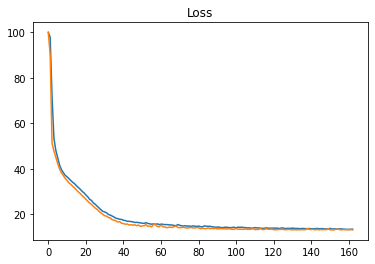

In [128]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [129]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [130]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 13.16%


In [131]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

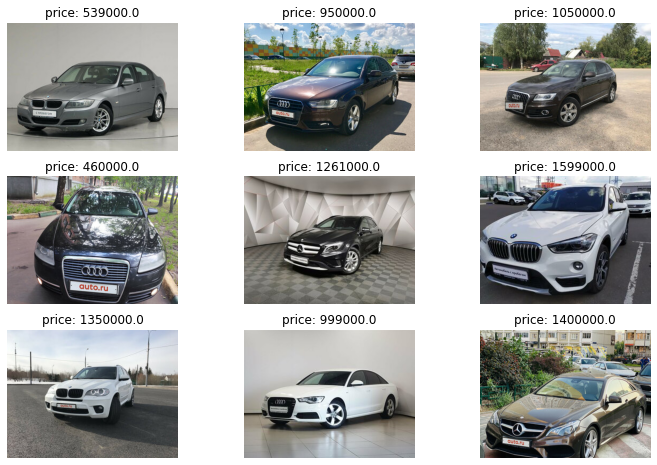

In [132]:


# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()



In [133]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


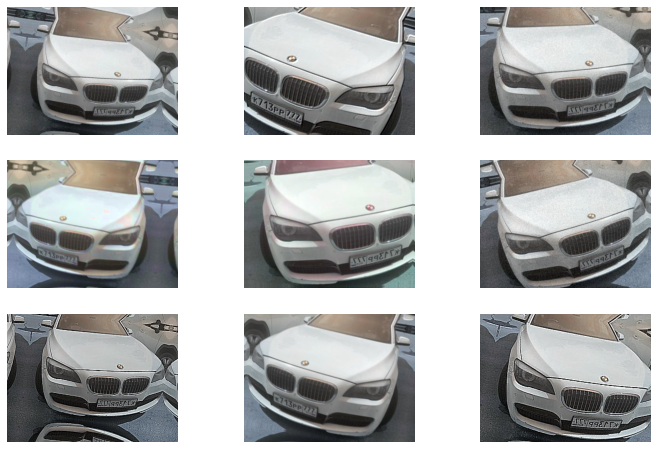

In [134]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [135]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [136]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return text

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [137]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train_sequences, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_test_sequences, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub_sequences, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();


In [138]:
K.clear_session()

In [139]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [140]:
efficientnet_model.input

<KerasTensor: shape=(None, 240, 320, 3) dtype=float32 (created by layer 'input_1')>

In [141]:
efficientnet_model.trainable = False


In [142]:
#efficientnet_model.summary()

In [143]:
#for layer in efficientnet_model.layers:
    #print(layer, layer.trainable)

## Fine Tuning. Step 1

In [144]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1], name="tabular"),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [145]:
tabular_model.input

<KerasTensor: shape=(None, 113) dtype=float32 (created by layer 'tabular')>

In [146]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [147]:
nlp_model.input

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'seq_description')>

In [148]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [149]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc5dd193210> False
<tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fc1659af150> False
<tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7fc164efa750> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fc164efa590> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc16812b250> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc164efa990> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc167fc6110> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fc166281310> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc1663bfa10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fc166990150> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D objec

In [150]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [151]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [152]:
history = model.fit(train_dataset.batch(30),
                    epochs=30,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/30
190/190 [==============================] - 125s 588ms/step - loss: 74.0442 - MAPE: 74.0442 - val_loss: 36.6917 - val_MAPE: 36.6917
Epoch 2/30
190/190 [==============================] - 103s 544ms/step - loss: 36.7515 - MAPE: 36.7515 - val_loss: 30.6891 - val_MAPE: 30.6891
Epoch 3/30
190/190 [==============================] - 105s 552ms/step - loss: 31.1085 - MAPE: 31.1085 - val_loss: 25.9462 - val_MAPE: 25.9462
Epoch 4/30
190/190 [==============================] - 106s 558ms/step - loss: 26.5119 - MAPE: 26.5119 - val_loss: 22.6550 - val_MAPE: 22.6550
Epoch 5/30
190/190 [==============================] - 105s 553ms/step - loss: 23.0134 - MAPE: 23.0134 - val_loss: 21.7769 - val_MAPE: 21.7769
Epoch 6/30
190/190 [==============================] - 98s 514ms/step - loss: 21.2104 - MAPE: 21.2104 - val_loss: 18.1035 - val_MAPE: 18.1035
Epoch 7/30
190/190 [==============================] - 111s 582ms/step - loss: 19.5016 - MAPE: 19.5016 - val_loss: 18.1466 - val_MAPE: 18.1466
Epoch 8

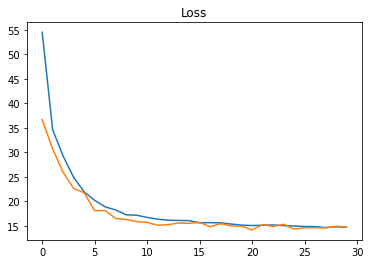

In [153]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [154]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [155]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 14.74%


## Fine Tuning. Step 2

In [156]:
efficientnet_model.trainable = True
# Fine-tune from this layer onwards
#fine_tune_at = int(len(base_model.layers)//2)

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
  #layer.trainable =  False

In [157]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [158]:
#for layer in model.layers:
    #print(layer, layer.trainable)

In [159]:
optimizer = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [160]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [161]:
history = model.fit(train_dataset.batch(30),
                    epochs=20,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/20
190/190 [==============================] - 154s 729ms/step - loss: 97.7071 - MAPE: 97.7071 - val_loss: 56.1915 - val_MAPE: 56.1915
Epoch 2/20
190/190 [==============================] - 134s 704ms/step - loss: 40.5300 - MAPE: 40.5300 - val_loss: 29.4183 - val_MAPE: 29.4183
Epoch 3/20
190/190 [==============================] - 135s 706ms/step - loss: 30.5837 - MAPE: 30.5837 - val_loss: 24.3904 - val_MAPE: 24.3904
Epoch 4/20
190/190 [==============================] - 133s 695ms/step - loss: 26.6531 - MAPE: 26.6531 - val_loss: 21.8794 - val_MAPE: 21.8794
Epoch 5/20
190/190 [==============================] - 139s 726ms/step - loss: 23.7683 - MAPE: 23.7683 - val_loss: 20.1969 - val_MAPE: 20.1969
Epoch 6/20
190/190 [==============================] - 135s 710ms/step - loss: 22.2041 - MAPE: 22.2041 - val_loss: 18.7740 - val_MAPE: 18.7740
Epoch 7/20
190/190 [==============================] - 135s 709ms/step - loss: 20.9853 - MAPE: 20.9853 - val_loss: 18.0799 - val_MAPE: 18.0799
Epoch 

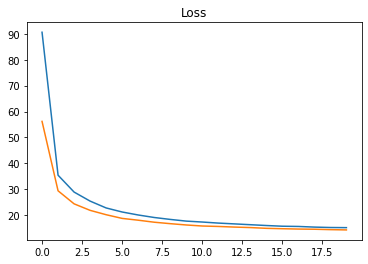

In [162]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [163]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [164]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 14.33%


In [165]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [166]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 12.15%


In [167]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [168]:
K.clear_session()

In [169]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [170]:
# FEATURE Input
# Iput
mileage = L.Input(shape=[1], name="mileage")
# Embeddings layers
emb_mileage = L.Embedding(len(X.mileage.unique().tolist())+1, 20)(mileage)
f_mileage = L.Flatten()(emb_mileage)

In [171]:
combinedInput = L.concatenate([model_mlp.output, f_mileage,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, mileage], outputs=head)


In [172]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 113)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          58368       dense_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
mileage (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [173]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [174]:
history = model.fit([X_train, X_train.mileage.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.mileage.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 1s 22ms/step - loss: 99.9966 - MAPE: 99.9966 - val_loss: 99.8708 - val_MAPE: 99.8708
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 99.3522 - MAPE: 99.3522 - val_loss: 93.8406 - val_MAPE: 93.8406
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 86.5079 - MAPE: 86.5079 - val_loss: 51.6117 - val_MAPE: 51.6117
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 52.9223 - MAPE: 52.9223 - val_loss: 48.6965 - val_MAPE: 48.6965
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 48.3409 - MAPE: 48.3409 - val_loss: 45.5419 - val_MAPE: 45.5419
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 44.9606 - MAPE: 44.9606 - val_loss: 42.5779 - val_MAPE: 42.5779
Epoch 7/500
12/12 [==============================] - 0s 8ms/step - loss: 41.7551 - MAPE: 41.7551 - val_loss: 40.0781 - val_MAPE: 40.0781
Epoch 8/500
12/12 [=====================

In [175]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.mileage.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")


TEST mape: 13.72%
